In [1]:
import h5py  
import torch
import numpy as np
from torch.utils import data
import json
from sklearn.preprocessing import normalize
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

In [2]:
# creates the dataset objects needed for training and testing

            
# splits a dataset into training and test data and does some preprocessing
class hdf5Dataset_init:
    def __init__(self, hdf5_filename, split=.3):
        self.hdf5_size = 0
        self.train_indices = []
        self.file_name = hdf5_filename
        self.index_hdf5 = [] 
        
        # min-max of data, min should always be zero so note stored
        self.max_array= None
        self.min_array = None
        self.initialize_indices()
        self.get_normalize_high_low()
    
    def initialize_indices(self):
        with h5py.File(self.file_name, 'r') as f:
            for gen in f.values():
                for trial in gen.values():
                    # index trial name 
                    self.index_hdf5.append(trial.name)
                    
                    # increments total number of data by number of datasets in specific trial
                    data_size = len(trial['data/positive_tests_total/all_runs'][...])
                    if data_size != 5:
                        print(data_size)
                        
                    # get total data inside
                    self.hdf5_size+=len(trial['data/positive_tests_total/all_runs'][...])
    
    # returns training and testing dataset for use
    def split_datasets(self, split, split_type):
        test_ind = []
        training_ind = []
            
            
        if split_type == "fully_random":
            # create list of indices
            indices = np.arange(self.hdf5_size)
            # shuffle that list
            np.random.shuffle(indices)
            print('split ind ', int(split*self.hdf5_size))
            test_ind, training_ind = np.split(indices, [int(split*self.hdf5_size), self.hdf5_size]#split*filesize gives size of test portion
                                             )[:2] # np.split returns 3rd empty arr so must ignore that
        elif split_type == 'parameter':
            indices = np.arange(self.hdf5_size//5) # get number of unique paramter sets
            np.random.shuffle(indices)
            test_num, training_num = np.split(indices, [int(split*self.hdf5_size//5), self.hdf5_size//5]#split*filesize gives size of test portion
                                             )[:2] # np.split returns 3rd empty arr so must ignore that
            
            # iterate through test parameter sets
            for i in test_num:
                # get each of the 5 indices that are part of that paramter set and add them to indice list
                for j in range(5):
                    test_ind.append((i*5)+j) # i*5+j gives the indice of each data set in that paramter
            
            for i in training_num:
                # get each of the 5 indices that are part of that paramter set
                for j in range(5):
                    training_ind.append((i*5)+j) # i*5+j gives the indice of each data set in that paramter
        else:
            print('select either \' parameter \' or \' fully_random \' for split_type')
            return
        
        #get device name
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # TRAINING
        training_inp = []
        training_output = []
        
        for ind in training_ind:
            combine = self.combine_data(ind)
            
            
            # only happens with bad output i.e -1, -1
            if combine is None:
                continue#append new item
            
            
            training_inp.append(combine[0])
            training_output.append(combine[1])
            
            #convert to numpy
        training_output = np.array(training_output,dtype=np.float32)
        training_inp = np.array(training_inp,dtype=np.float32)
        
        # convert output to log form
        training_output = np.log(training_output, where=(training_output!=0))

        
        #convert from numpy to torch
        training_inp = torch.from_numpy(training_inp)
        training_output = torch.from_numpy(training_output)
        
        # convert to device type
        training_output = training_output.to(device)
        training_inp = training_inp.to(device)

        trainingTensor = TensorDataset(training_inp, training_output)
        
         # TESTING
        testing_inp = []
        testing_output = []
        
        for ind in test_ind:
            combine = self.combine_data(ind)
            
            #check if datset is bad and pass if yes
            if combine is None:
                continue 
            #append new item
            testing_inp.append(combine[0])
            testing_output.append(combine[1])
            
            #convert to numpy
        testing_output = np.array(testing_output,np.float32)
        testing_inp = np.array(testing_inp,dtype=np.float32)

        # get the log version of the output
        testing_output = np.log(testing_output, where=(testing_output!=0))
        
        #convert from numpy to torch
        testing_inp = torch.from_numpy(testing_inp)
        testing_output = torch.from_numpy(testing_output)
        
        # convert to device type and float
        testing_output = testing_output.to(device)
        testing_inp = testing_inp.to(device)
        
        testingTensor = TensorDataset(testing_inp, testing_output)
        
        #convert to float for neural network
        return trainingTensor, testingTensor
            
        
    def combine_data(self, indice):
        target_group = self.index_hdf5[indice//5] # get larger group name which contrains 5 datasets
        inner_index = indice % 5 # get index of group within the 5
        data = []
        with h5py.File(self.file_name, 'r') as F:
            trial = F[target_group] # get the specified indexs trial group
            params = json.loads(trial['parameters'][...].tolist()) # get the parameters
            cleaned_dict = self.transform_dict(params)
            run_data = []
            for item in trial['data'].values(): # get parameters objects
                data = item['all_runs'][...][inner_index]
                run_data.append(item['all_runs'][...][inner_index]) # get indexed runs data 
                
            np_run = np.array(run_data) 
            
            return cleaned_dict, run_data
                
                 
    # get high and lows for parameters to allow for min_max standardizationk
        
    # do some preprocessing on dictionary
    def transform_dict(self,dictionary, normalize=True):
        # remove unnessarry items from the parameter dictionarys
        bad_params = ['test','verbose','attendance_bins','scenario_name','parameter_checking',
                      'run_days', 'daily_outside_cases','removed_cohorts']
        for param in bad_params:
            dictionary.pop(param, 'None')
        # convert vlaues to numpy array format
        dict_vals = np.array(list(dictionary.values()))
        
        
        # normalize the inputs
        if normalize:
            dict_vals = (np.subtract(dict_vals, self.min_array))/self.max_array
            
        
        return dict_vals
    
    def get_normalize_high_low(self):
        size = 512 if self.hdf5_size > 512 else self.hdf5_size-1
        print(size)
        random_sample = np.random.randint(0, high=self.hdf5_size, size=size)
        
        
        array = []
        # find min max for randomzied items from dataset
        with h5py.File(self.file_name, 'r') as F:
            
            for rand in random_sample:
                
                dict_P = json.loads(F[self.index_hdf5[rand//5]]['parameters'][...].tolist()) # get param dictionary
                values = self.transform_dict(dict_P, normalize=False)
                # first iteration
                if rand == random_sample[0]:
                    array = values
                else:
                    array = np.vstack((array, values))
            print(array.shape)
            self.max_array = np.amax(array, axis=0)
            self.min_array = np.amin(array, axis=0)
            print('min and max arrays', '*'*40)
            print(self.max_array)
            print(self.min_array)
        
                
initset = hdf5Dataset_init('full_data.hdf5')   
training, testing = initset.split_datasets(.3, 'parameter')





512
(367, 29)
min and max arrays ****************************************
[1.00000000e+00 1.00000000e+00 9.87019820e-03 9.91668957e-02
 1.02499145e+01 1.15502592e+01 4.91553523e-01 2.70000000e+01
 2.70000000e+01 5.00000000e+00 7.44061814e+00 3.70000000e+01
 9.90648797e-01 1.91668743e+00 1.95735015e+00 3.00000000e+00
 9.64972596e-04 1.92093207e-03 5.89265722e-02 2.89000000e+02
 1.96224243e+00 7.62841825e+00 7.83786620e+00 3.91116632e+00
 7.84149183e+00 7.92824128e+00 1.97422196e+00 1.83000000e+02
 1.00000000e+00]
[0.00000000e+00 0.00000000e+00 5.48435879e-04 2.11330700e-03
 1.50000000e+00 1.50000000e+00 2.18193388e-02 1.00000000e+00
 0.00000000e+00 0.00000000e+00 4.19716997e-01 1.00000000e+00
 3.88520533e-02 5.15857934e-02 2.91319616e-02 0.00000000e+00
 2.00675138e-05 6.36203244e-05 2.56914045e-03 1.40000000e+01
 2.89717330e-02 3.00873761e-01 8.23264199e-02 1.37828377e-01
 1.75301395e-01 3.13446209e-01 5.89111197e-02 6.00000000e+00
 0.00000000e+00]


In [3]:
print(initset.hdf5_size)
print(len(training))
print(len(testing))
print(training[1][0])
print(training[100][1])

47710
33400
14310
tensor([0.0000, 0.0000, 0.4096, 0.6238, 0.5578, 0.8083, 0.5255, 0.5185, 0.4815,
        0.8000, 0.5521, 0.0541, 0.5004, 0.0730, 0.4146, 0.0000, 0.2635, 0.6182,
        0.5858, 0.5571, 0.4764, 0.2804, 0.9010, 0.6922, 0.8790, 0.5334, 0.3589,
        0.5137, 1.0000], device='cuda:0')
tensor([[0.0000, 3.5835, 4.0254, 4.3041, 4.6540, 4.7536, 4.8675, 5.2627, 5.4931,
         5.8493, 6.1048, 6.3835, 6.4615, 6.5709, 6.9470, 7.1701, 7.4765, 7.6709,
         7.8755, 7.9334, 7.9848, 8.2242, 8.3405, 8.5000, 8.5852, 8.6649, 8.6694,
         8.6766, 8.7378, 8.7776, 8.8226, 8.8078, 8.8010, 8.7354, 8.6766, 8.6174,
         8.6019, 8.5949, 8.4461, 8.3511, 8.1651, 8.0166, 7.8644, 7.8248, 7.7803,
         7.5501, 7.3889, 7.1333, 6.9373, 6.7286, 6.6946, 6.6503, 6.4378, 6.2897,
         6.0307, 5.8319, 5.6904, 5.6419, 5.5947, 5.3375, 5.1930, 4.9904, 4.8363,
         4.6913, 4.6347, 4.6151, 4.3820, 4.1897, 3.8918, 3.6889, 3.5553, 3.4657,
         3.3673, 3.2189, 3.0445, 2.9444, 2.6391, 2.5

In [4]:
import torch.nn.functional as F
import torch.nn as nn

class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linput = nn.Linear(29, 150)
        self.lhidden = nn.Linear(150, 300)
        self.lhidden2 = nn.Linear(300,600)
        self.lhidden3 = nn.Linear(600, 300)
        self.lhidden4 = nn.Linear(300, 150)
        
        
        
        self.output10 = nn.Linear(150,300)
        self.output11 = nn.Linear(300,150)
        self.output12 = nn.Linear(150,128)
        
        self.output20 = nn.Linear(150, 300)
        self.output21 = nn.Linear(300, 150)
        self.output22 = nn.Linear(150,128)    
  
        
        self.output30 = nn.Linear(150,300)                
        self.output31 = nn.Linear(300,150)
        self.output32 = nn.Linear(150,128)
        
        
        
        self.leakyrelu = nn.LeakyReLU(1e-2)
        
    def forward(self, x, verbose=False):
        #simple network
        x = self.leakyrelu(self.linput(x))
        if verbose:
            print('input', x)
        x = self.leakyrelu(self.lhidden(x))
        #if verbose:
            #print('hidden 1', x)
        x = self.leakyrelu(self.lhidden2(x))
        if verbose:
            print('hidden 2', x)        
        x = self.leakyrelu(self.lhidden3(x))
        x = self.leakyrelu(self.lhidden4(x))
        if verbose:
            print('hidden 4', x)    
        
        # data specific heads
        x1 = self.leakyrelu(self.output10(x))
        x1 = self.leakyrelu(self.output11(x1)) 
        x1_output = self.leakyrelu(self.output12(x1))
        if verbose:
            print('output 12', x)   
            
        x2 = self.leakyrelu(self.output20(x))
        x2 = self.leakyrelu(self.output21(x2)) 
        x2_output = self.leakyrelu(self.output22(x2))
        
        if verbose:
            print('output 22', x2)  
        
        x3 = self.leakyrelu(self.output30(x))
        x3 = self.leakyrelu(self.output31(x3))
        x3_output = self.leakyrelu(self.output32(x3))
        if verbose:
            print('output 32', x3)  
        
        
        
        
        return x1_output, x2_output, x3_output
        
        
        

In [5]:
def get_high_low_output(data_loader):
    high1 = high2 = high3 = 0
    low1 = low2 = low3 = float('inf')
    for d,t in data_loader:
        
        max_val = torch.max(t[:,0])
        min_val = torch.min(t[:,0])
        if max_val > high1:
            high1 = max_val
        if min_val < low1:
            low1 = min_val
            
            
        max_val = torch.max(t[:,1])
        min_val = torch.min(t[:,1])
        if max_val > high2:
            high2 = max_val
        if min_val < low2:
            low2 = min_val
            
        max_val = torch.max(t[:,2])
        min_val = torch.min(t[:,2])
        if max_val > high3:
            high3 = max_val
        if min_val < low3:
            low3 = min_val
        
        
    return (low1, high1),(low2, high2), (low3, high3)


In [6]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [7]:

model = Network2()
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# get min, max for standardization for each of the variables.
stand1, stand2, stand3 =  get_high_low_output(train_loader)

In [8]:
for d,t in train_loader:
    max_val = torch.max(t[:,0])
    min_val = torch.min(t[:,0])
    standardized_data = (t[:,0]-min_val)/max_val
    print(max_val)
    print(min_val)
    print(standardized_data)
    print('standardized_max', torch.max(standardized_data))
    print('-'*40)

tensor(9.3284, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4893, 0.4968,  ..., 0.1725, 0.1921, 0.2086],
        [0.0000, 0.4057, 0.4127,  ..., 0.1178, 0.0743, 0.0743],
        [0.0000, 0.4787, 0.4800,  ..., 0.1725, 0.1725, 0.1921],
        ...,
        [0.0000, 0.4236, 0.4424,  ..., 0.1921, 0.2229, 0.2229],
        [0.0000, 0.3954, 0.4194,  ..., 0.1725, 0.1486, 0.1178],
        [0.0000, 0.3646, 0.4507,  ..., 0.2086, 0.1921, 0.1921]],
       device='cuda:0')
standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.3114, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4064, 0.4483,  ..., 0.0744, 0.0744, 0.1180],
        [0.0000, 0.5509, 0.6780,  ..., 0.0744, 0.1180, 0.1489],
        [0.0000, 0.4637, 0.4719,  ..., 0.2978, 0.3043, 0.3043],
        ...,
        [0.0000, 0.2834, 0.3270,  ..., 0.2090, 0.1924, 0.1924],
        [0.0000, 0.3962, 0.3962,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4532, 0.4651,  ..., 

       device='cuda:0')
standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.3328, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4473, 0.4773,  ..., 0.2748, 0.2663, 0.2569],
        [0.0000, 0.4422, 0.4582,  ..., 0.5065, 0.5065, 0.5037],
        [0.0000, 0.4695, 0.4722,  ..., 0.2663, 0.2663, 0.2569],
        ...,
        [0.0000, 0.3953, 0.4102,  ..., 0.4387, 0.4332, 0.4213],
        [0.0000, 0.4668, 0.2467,  ..., 0.0000, 0.0743, 0.0000],
        [0.0000, 0.4976, 0.5139,  ..., 0.4005, 0.4005, 0.3925]],
       device='cuda:0')
standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.2970, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4554, 0.4630,  ..., 0.1927, 0.2093, 0.1927],
        [0.0000, 0.2093, 0.2363,  ..., 0.1491, 0.1182, 0.1182],
        [0.0000, 0.3793, 0.3824,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.4816, 0.4975,  ..., 0.1491, 0.1731, 0.

standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.3151, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4621, 0.5084,  ..., 0.3498, 0.3456, 0.3216],
        [0.0000, 0.5006, 0.5148,  ..., 0.2574, 0.2754, 0.2907],
        [0.0000, 0.5175, 0.5266,  ..., 0.2089, 0.2089, 0.1924],
        ...,
        [0.0000, 0.4877, 0.5888,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3456, 0.3847,  ..., 0.1728, 0.1728, 0.1728],
        [0.0000, 0.4663, 0.4769,  ..., 0.1924, 0.1728, 0.1924]],
       device='cuda:0')
standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.3095, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.5195, 0.5707,  ..., 0.2090, 0.2090, 0.1925],
        [0.0000, 0.5195, 0.6352,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4324, 0.4484,  ..., 0.1489, 0.1489, 0.1489],
        ...,
        [0.0000, 0.3540, 0.3788,  ..., 0.1180, 0.0000, 0.0000],
        [0.0000, 

tensor(9.3313, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.3747, 0.3926,  ..., 0.1920, 0.2228, 0.2228],
        [0.0000, 0.2355, 0.2468,  ..., 0.2971, 0.3036, 0.2971],
        [0.0000, 0.4234, 0.4474,  ..., 0.3870, 0.3898, 0.3980],
        ...,
        [0.0000, 0.5280, 0.5799,  ..., 0.2570, 0.2570, 0.2828],
        [0.0000, 0.2663, 0.2663,  ..., 0.1725, 0.1725, 0.1920],
        [0.0000, 0.4798, 0.4810,  ..., 0.2085, 0.1920, 0.2085]],
       device='cuda:0')
standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.3199, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4512, 0.4559,  ..., 0.1727, 0.1923, 0.1727],
        [0.0000, 0.4445, 0.4779,  ..., 0.1179, 0.0744, 0.0000],
        [0.0000, 0.4741, 0.4852,  ..., 0.2975, 0.2975, 0.3267],
        ...,
        [0.0000, 0.4897, 0.5110,  ..., 0.2666, 0.2666, 0.2471],
        [0.0000, 0.4897, 0.4962,  ..., 0.0744, 0.0744, 0.0744],
        [0.0000, 0.4930, 0.5198,  ..., 

tensor(9.3114, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4432, 0.4500,  ..., 0.1180, 0.1180, 0.1489],
        [0.0000, 0.4180, 0.4304,  ..., 0.1180, 0.1489, 0.1489],
        [0.0000, 0.4500, 0.4759,  ..., 0.2473, 0.2473, 0.2233],
        ...,
        [0.0000, 0.3367, 0.3616,  ..., 0.1924, 0.2090, 0.2090],
        [0.0000, 0.4135, 0.4201,  ..., 0.1180, 0.1180, 0.1180],
        [0.0000, 0.4796, 0.4821,  ..., 0.0744, 0.0744, 0.1180]],
       device='cuda:0')
standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.3279, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.3871, 0.3981,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3780, 0.3955,  ..., 0.0000, 0.0743, 0.1178],
        [0.0000, 0.4904, 0.5251,  ..., 0.2356, 0.2356, 0.2356],
        ...,
        [0.0000, 0.4334, 0.4371,  ..., 0.0000, 0.0743, 0.0000],
        [0.0000, 0.2829, 0.2829,  ..., 0.2664, 0.2664, 0.2469],
        [0.0000, 0.4643, 0.4684,  ..., 

       device='cuda:0')
standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.2932, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4231, 0.4540,  ..., 0.5551, 0.5545, 0.5475],
        [0.0000, 0.3795, 0.4120,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4877, 0.4977,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.2983, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3826, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2580, 0.2674,  ..., 0.1182, 0.1732, 0.1492]],
       device='cuda:0')
standardized_max tensor(1., device='cuda:0')
----------------------------------------
tensor(9.2915, device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0.0000, 0.4459, 0.4572,  ..., 0.0000, 0.0746, 0.0746],
        [0.0000, 0.5125, 0.5255,  ..., 0.4313, 0.4273, 0.4121],
        [0.0000, 0.4703, 0.4946,  ..., 0.1182, 0.1182, 0.0746],
        ...,
        [0.0000, 0.2840, 0.2840,  ..., 0.3224, 0.3224, 0.

In [20]:

'''
Might need to normalize output since the cases are often so much higher than the active, it means it will be more greatly
considered for loss, which is why the model has trouble.
'''


epochs = 200
gamma = 1e-2
# Loop over the data
loss_totals = []
loss_test_totals = []
temp_total = []
loss = float('inf')
for epoch in range(epochs):
    # Loop over each subset of data
    for d,t in train_loader:
        # Zero out the optimizer's gradient buffer+
        optimizer.zero_grad()
        # Make a prediction based on the model
        outputs = model(d)
        # Compute the loss+
        
        #standardize the output first
        
        
        s_t0 = (t[:,0]-stand1[0])/(stand1[1]-stand1[0])
        s_o0 = (outputs[0]-stand1[0])/(stand1[1]-stand1[0])
        loss0 =  criterion(s_o0,s_t0)
        
        
        s_t1 = (t[:,1]-stand2[0])/(stand2[1]-stand2[0])
        s_o1 = (outputs[1]-stand2[0])/(stand2[1]-stand2[0])
        loss1 =  criterion(s_o1,s_t1)


        s_t2 = (t[:,2]-stand3[0])/(stand3[1]-stand3[0])
        s_o2 = (outputs[2]-stand3[0])/(stand3[1]-stand3[0])
        loss2 = criterion(s_o2, s_t2)
       

        
        
    
        loss = loss0 + loss1 + loss2
        
        
        
        
        loss_totals.append(loss)
        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        '''
        print('grad', model.output22.weight.grad)
        print('='*20)
        print('bias', model.output22.bias)
        print('='*20)
        '''

        # Use the derivative information to update the parameters
        optimizer.step()
    print('finsiehd epoch {}'.format(epoch))
    if epoch %10 == 0:
        print('loss', loss)
        print('*'*50)
    
    
print('finished training')    

finsiehd epoch 0
loss tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)
**************************************************
finsiehd epoch 1
finsiehd epoch 2
finsiehd epoch 3
finsiehd epoch 4
finsiehd epoch 5
finsiehd epoch 6
finsiehd epoch 7
finsiehd epoch 8
finsiehd epoch 9
finsiehd epoch 10
loss tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)
**************************************************
finsiehd epoch 11
finsiehd epoch 12
finsiehd epoch 13
finsiehd epoch 14
finsiehd epoch 15
finsiehd epoch 16
finsiehd epoch 17
finsiehd epoch 18
finsiehd epoch 19
finsiehd epoch 20
loss tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)
**************************************************
finsiehd epoch 21
finsiehd epoch 22
finsiehd epoch 23
finsiehd epoch 24
finsiehd epoch 25
finsiehd epoch 26
finsiehd epoch 27
finsiehd epoch 28
finsiehd epoch 29
finsiehd epoch 30
loss tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)
**************************************************
fins

In [10]:
for d,t in train_loader:
    print('%'*20)
    print('before normalize')
    print(t[:,1])
    print('%'*40)
    print('after normalize')
    s_t1 = (t[:,1]-stand2[1])/(stand2[1]-stand2[0])
    print(s_t1)

%%%%%%%%%%%%%%%%%%%%
before normalize
tensor([[ 0.0000,  0.0000,  1.0986,  ..., 11.8517, 11.8517, 11.8517],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.3026,  2.3026,  2.3026],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.4360,  9.4416,  9.4466],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  4.4427,  4.4427,  4.4427],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  3.4012,  3.4012,  3.4012]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
after normalize
tensor([[-1.0000, -1.0000, -0.9119,  ..., -0.0499, -0.0499, -0.0499],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8154, -0.8154, -0.8154],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2435, -0.2431, -0.2427],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -0.6438, -0.6438, -0.6438],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7273, -0.7273, -0.7273]],
       device

%%%%%%%%%%%%%%%%%%%%
before normalize
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  3.4657,  3.4657,  3.4965],
        [ 0.0000,  0.0000,  0.0000,  ..., 11.6120, 11.6120, 11.6120],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  2.3026,  2.3026,  2.3026],
        [ 0.0000,  0.0000,  0.0000,  ...,  3.6889,  3.6889,  3.6889],
        [ 0.0000,  0.0000,  0.0000,  ...,  3.0910,  3.0910,  3.0910]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
after normalize
tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7222, -0.7222, -0.7197],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0691, -0.0691, -0.0691],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -0.8154, -0.8154, -0.8154],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7043, -0.7043, -0.7043],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7522, -0.7522, -0.7522]],
       device

%%%%%%%%%%%%%%%%%%%%
before normalize
tensor([[0.0000, 0.0000, 0.0000,  ..., 3.9318, 3.9318, 3.9318],
        [0.0000, 0.0000, 0.0000,  ..., 1.3863, 1.3863, 1.3863],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 5.6768, 5.6768, 5.6768],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
after normalize
tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6848, -0.6848, -0.6848],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8889, -0.8889, -0.8889],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5449, -0.5449, -0.5449],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%
befo

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.8904,  2.8904,  2.8904],
        [ 0.0000,  0.0000,  0.0000,  ..., 11.3448, 11.3448, 11.3448],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  8.9118,  8.9118,  8.9118],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
after normalize
tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7683, -0.7683, -0.7683],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0905, -0.0905, -0.0905],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -0.2856, -0.2856, -0.2856],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%
before

%%%%%%%%%%%%%%%%%%%%
before normalize
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.6931,  0.6931,  0.6931],
        [ 0.0000,  0.0000,  0.0000,  ...,  5.8522,  5.8522,  5.8522],
        [ 0.0000,  0.0000,  0.0000,  ...,  3.6376,  3.6376,  3.6376],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., 12.1905, 12.1905, 12.1905],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.6931,  0.6931,  0.6931],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.6931,  0.6931,  0.6931]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
after normalize
tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.9444, -0.9444, -0.9444],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5308, -0.5308, -0.5308],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7084, -0.7084, -0.7084],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -0.0227, -0.0227, -0.0227],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9444, -0.9444, -0.9444],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9444, -0.9444, -0.9444]],
       device

       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%
before normalize
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.3863,  1.3863,  1.3863],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  4.2767,  4.2767,  4.2767],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.2387, 10.2387, 10.2387],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
after normalize
tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8889, -0.8889, -0.8889],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -0.6572, -0.6572, -0.6572],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1792, -0.1792, -0.1792],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, 

       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%
before normalize
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 2.7081, 2.7081, 2.7081],
        [0.0000, 0.0000, 0.0000,  ..., 2.9957, 2.9957, 2.9957],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 3.4012, 3.4012, 3.4012],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
after normalize
tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7829, -0.7829, -0.7829],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7598, -0.7598, -0.7598],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -0.7273, -0.7273, -0.7273],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')
%

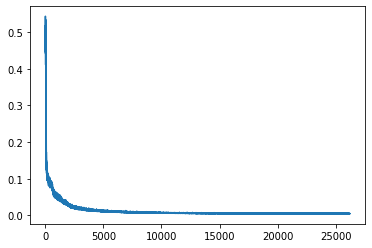

In [11]:
plt.plot(loss_totals)
plt.show()

In [12]:
print(loss)

    

tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)


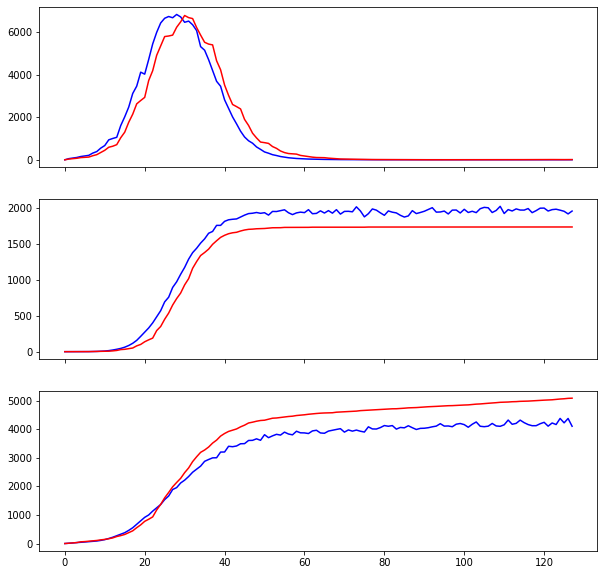

In [31]:
plt.rcParams["figure.figsize"] = (10,10)
def compare_model(model1, training, index):
    
    fig, axs = plt.subplots(3, sharex=True)
    #model.eval()
    #print(training[index][0])
    output1 = model1(training[index][0])
    #output2 = model2(training[index][0])
    output_list_1 = list(output1)
    #output_list_2 = list(output2)
    train_view = training[index][1].cpu().numpy()

    for i in range(3):
        output_numpy_1 = output_list_1[i].cpu().data.numpy()
        #output_numpy_2 = output_list_2[i].cpu().data.numpy()
        
        e_output = np.exp(output_numpy_1)
        e_training = np.exp(train_view[i])
        
        #e_output = output_numpy_1
        
        #e_training = train_view[i]
        
        
        axs[i].plot(e_output, 'b', 
            e_training, 'r',
                    #output_numpy_2, 'g'
                   )

    plt.show()
compare_model(model, training, 100)

In [14]:
# model interogation

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model.linput.register_forward_hook(get_activation('linput'))
model.lhidden.register_forward_hook(get_activation('lhidden'))
model.lhidden2.register_forward_hook(get_activation('lhidden2'))
model.lhidden2.register_forward_hook(get_activation('output22'))
output = model(training[0][0], verbose=True)
print('='*50)
print(output)
#print('input', activation['linput'])
print('*'*40)
#print('lhidden', activation['lhidden'])
print('*'*40)
#print('hidden 2 ', activation['lhidden2'])
print('*'*40)
print('output 22 ', activation['output22'])



input tensor([ 4.0204e-01, -4.4975e-03,  8.2486e-02,  2.9638e-01,  6.9620e-02,
         2.7607e-01,  4.7474e-02, -4.0065e-04,  2.3723e-01,  3.2443e-02,
         7.3717e-02, -1.2988e-05,  1.9541e-01,  6.7694e-01,  1.0305e-01,
         1.8168e-01,  5.6214e-01,  2.1675e-01,  1.8157e-01, -2.8431e-03,
         1.4890e-01,  4.5691e-01,  4.1767e-01,  2.3853e-01,  2.0079e-01,
        -1.3171e-03,  2.1227e-01,  5.6811e-01,  2.2910e-01,  1.3403e-01,
         5.2144e-01,  5.7359e-01, -1.3398e-03, -1.5322e-03, -6.2890e-04,
        -2.5546e-03,  7.7800e-01,  3.3161e-01,  3.0329e-02,  4.5895e-01,
         9.2642e-02, -3.7519e-03,  1.5937e-01,  2.9013e-01,  3.2694e-01,
         8.9384e-01, -4.8167e-03,  4.3234e-01,  3.4805e-02,  4.2153e-01,
         6.8489e-02,  2.5017e-01,  3.3473e-01,  4.9541e-01,  5.2861e-01,
        -1.4586e-03,  3.8119e-01, -1.3544e-03,  2.7962e-01, -3.0902e-03,
        -2.7131e-04,  2.7099e-01,  2.8032e-01, -5.2706e-03, -1.7903e-03,
         3.0756e-01,  1.9295e-01, -1.0712e-03

In [15]:
#PATH = 'surragote_model.pt'

#torch.save(model.state_dict(), PATH)




In [16]:
print(initset.min_array)

[0.00000000e+00 0.00000000e+00 5.48435879e-04 2.11330700e-03
 1.50000000e+00 1.50000000e+00 2.18193388e-02 1.00000000e+00
 0.00000000e+00 0.00000000e+00 4.19716997e-01 1.00000000e+00
 3.88520533e-02 5.15857934e-02 2.91319616e-02 0.00000000e+00
 2.00675138e-05 6.36203244e-05 2.56914045e-03 1.40000000e+01
 2.89717330e-02 3.00873761e-01 8.23264199e-02 1.37828377e-01
 1.75301395e-01 3.13446209e-01 5.89111197e-02 6.00000000e+00
 0.00000000e+00]
